In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

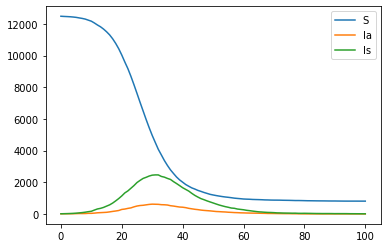

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

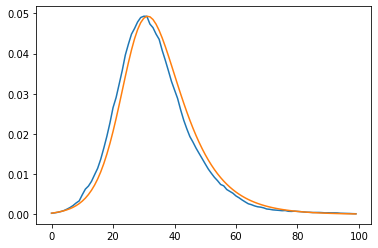

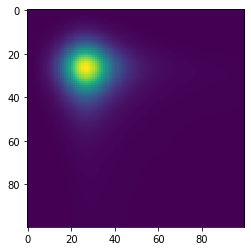

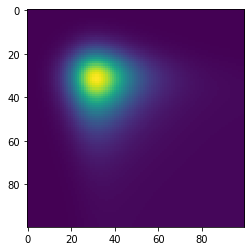

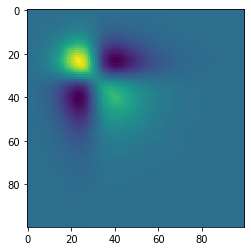

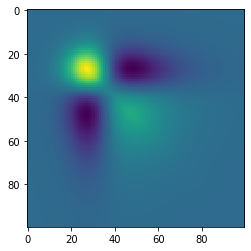

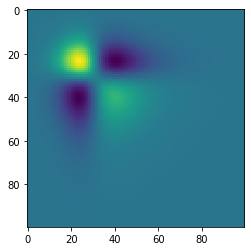

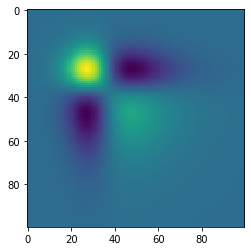

In [7]:
# load the data and rescale to intensive variables 
Tf = 100 # can truncate later 
Nf = Tf+1

x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, True]), 2)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SIR(parameters, M, fi)
xm,full_cov = estimator.obtain_full_mean_cov(x[0,:], Tf, Nf, det_model, contactMatrix)
full_cov = full_cov.todense()
plt.plot(x[1:,2*M])
plt.plot(xm[:,2*M])
plt.show()
for i in range(6):
    plt.imshow(full_cov[i::6,i::6])
    plt.show()

In [8]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

557.1578943887382
0.9309968948364258


In [11]:
alpha_g = 0.2
beta_g = 0.07
gIa_g = 0.145
gIs_g = 0.145
fsa_g = 0.8

S0_g = S0/N
Ia0_g = Ia0/N

# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-3 # the relative tol in (-logp)  

# set up bounds for Ia and S 
bounds_for_Ia = [(0.1/N, 100/N)]*M
bounds_for_Is = [(6/N, 14/N)]*M 
bounds_for_S = [(fi[i]-100/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# set up bounds for the rest of the params 
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([(0.1, 0.5), (eps, 0.1), (eps, 0.5), (0.13, 0.15), *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0])
params = estimator.latent_inference(guess, obs, fltr, Tf, Nf, contactMatrix, 
                                    bounds, verbose=True, niter=2, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.16713858 0.04702987 0.26165804 0.14007079]
parameters: [0.13356925 0.02356491 0.38082915 0.14004018]
parameters: [0.13324279 0.02325729 0.38203378 0.14010618]
parameters: [0.13197429 0.02187045 0.38686272 0.14046977]
parameters: [0.13192983 0.02158158 0.38721278 0.14060272]
parameters: [0.13243791 0.02124396 0.38596007 0.14090915]
parameters: [0.13412291 0.02102133 0.38117303 0.14151092]
parameters: [0.1370772  0.02125934 0.37285694 0.14257966]
parameters: [0.14211991 0.0216647  0.35877212 0.14448365]
parameters: [0.14945704 0.02235163 0.33831076 0.14725997]
parameters: [0.14903742 0.02223193 0.33953428 0.14712583]
basinhopping step 0: f 558.529
parameters: [0.16321805 0.04101754 0.399226   0.13379308]
parameters: [0.14232706 0.02749596 0.43252771 0.13660708]
parameters: [0.13603297 0.0233162  0.44256111 0.13779156]
parameters: [0.13545705 0.02288364 0.44350214 0.13794133]
parameters: [0.1342432  0.02185288 0.44554816 0.13832632]
parameters: [0.13337193 0.02097344 0.4471

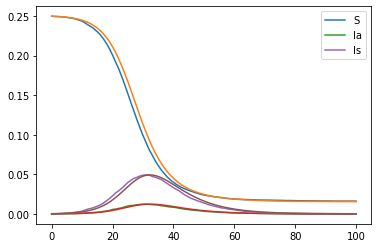

In [13]:
parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3],'fsa':0.8}
estimator.set_params(parameters)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()